In [1]:
# standard ds imports
import numpy as np
import pandas as pd

# for wrangling and exploration
import mvp_wrangle
import mvp_explore
import mvp_model

# for statistical testing
import scipy.stats as stats

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

# filter out noise
import warnings
warnings.filterwarnings('ignore')

# align markdown tables to the left

In [2]:
%%html
<style>
table {float:left}
</style>

# MYERS BRIGGS TWITTER ASSESSMENT

For company managers who are dissatisfied with currently available group assignment practices. Our service is a psychographic segmentation solution that enhances workplace efficiency and improves employee satisfaction. We harnessed the power of artificial intelligence to create a personality profile predictor that is based on assessment of orgainic text as opposed to intrusive, biased self-reporting. Management uses this more accurate classifiation to build structured, efficient, and satisfied teams. 

<img src='twitter_bird_wordcloud.png' alt='twitter' width='500'/>

----

## Executive Summary:

Goals:
- Analyze relationships between tweets and the myers briggs 16 personalities
- Build a classification model to predict a personality type based on a user's tweets

Key Findings:
- Exploring domains produces more distinct contrast between groups than looking at all 16 personability types individually

Takeaways:
- Our best model looking at all 16 personalities, a multinomial Naive Bayes using TF-IDF, performed at 17.5% accuracy on the test dataset. This barely outperforms the baseline at 17.2%
- There is likely higher accuracy when modeling to domain instead of the 16 types

Recommendations:
- Due to the low accuracy, it is not recommended to use this for individual predictions
- However, looking at how types and domains interact can provide business insights for targeted marketing and training for known personality types

----
## 1. Planning
 - Create deliverables:
     - README
     - final_report.ipynb
     - working_report.ipynb
     - canva presentation
 - Bring over functional wrangle.py, explore.py, and model.py files
 - Acquire the data from the Kaggle and Twitter via acquire.py's web scraping. Save the data locally.
 - Prepare and split the data via the prepare.py functions
 - Explore the data and define hypothesis. Run the appropriate statistical tests in order to accept or reject each null hypothesis. Document findings and takeaways.
 - Model a baseline in predicting personality type and document the accuracy.
 - Fit and train classification models to predict personality type or domain on the train dataset.
 - Evaluate the models by comparing the train and validation data.
 - Select the best model and evaluate it on the train data.
 - Develop and document all findings, takeaways, recommendations and next steps.

----
## 2. Data Wrangling
This step calls the wrangle function from the wrangle.py. This function:
- Acquires the data and utilizes a pickle file to save it locally
- Cleans the data using the nltk tokenizer and lemmitizer
- Handles nulls
- Feature engineers:
    - personality_domain -> bins the 16 personalities to their domain
    - sentiment -> compound score using the Senitment Intensity Analyzer
    - message_length -> count of characters in each tweet after lemmitization
    - word_count -> count of words in each tweet after lemmitization
    - personality pairs -> creates boolean features for each pair
- Splits the data into 60/20/20 for train, validate, and test datasets

#### Data Dictionary

| Target | Type | Description |
| ---- | ---- | ---- |
| type | str | the 16 myers briggs personality types |

| Feature Name | Type | Description |
| ---- | ---- | ---- |
| name | str | the owner of the twitter account scraped |
| lemmatized | str | the lemmatized version of past 100 tweets scraped by user |
| personality_domain | str | which of the 4 domains the personality type is in |
| sentiment | float | the compound sentiment score |
| message_length | int | the count of characters in the combined 100 tweets after lemmatization |
| word_count | int | the count of words in the combined 100 tweets after lemmatization |
| i_e | int | i for introvert, e for extrovert |
| s_n | int | s for sensing, n for intuitive |
| f_t | int | f for feeling, t for thinking |
| p_j | int | p for perceiving, j for judging |

In [5]:
# call the wrangle function from wrangle.py
df = mvp_wrangle.wrangle()

In [6]:
# split
train, val, test = mvp_wrangle.split_data(df)

In [5]:
# verify the split
train.shape, val.shape, test.shape

((359, 11), (120, 11), (120, 11))

### Wrangling Takeaways
- The data acquired contains 599 celebrities most recent 100 tweets over 3 features
- Feature engineered an additional 8 features to support further exploration

----
## 2. Data Exploration

### What does the data look like?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


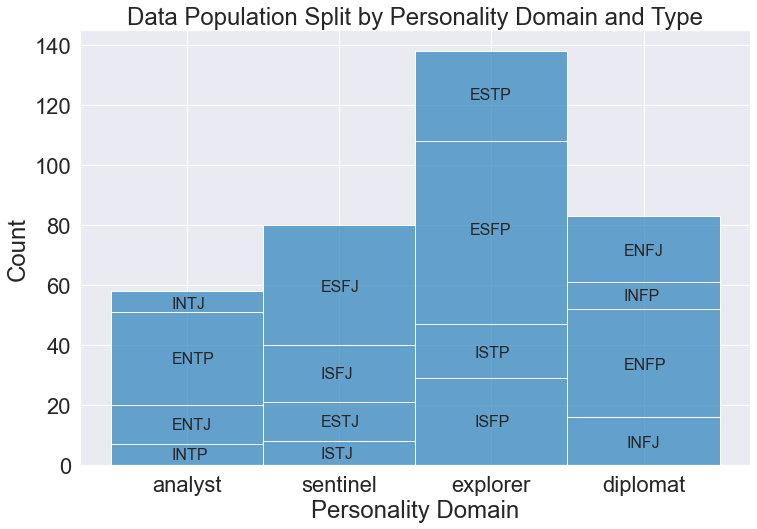

In [7]:
# show the overall visualization
mvp_explore.overall_data_vis(train)

### Question 1: What scale of groupings shows a significant relationship in sentiment? Pairs, types, or domains?

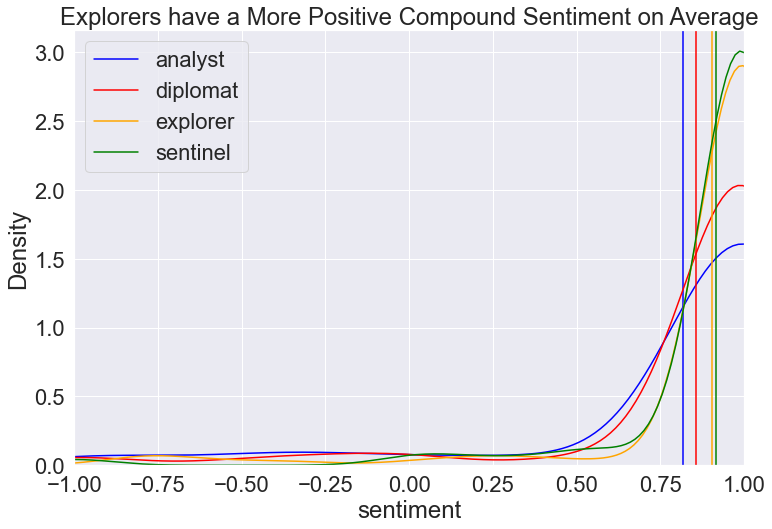

In [8]:
# show the viz for q1
mvp_explore.q1_vis(train)

#### Hypothesis 1:

    Ho -> The mean sentiment for explorers is less than or equal to the mean sentiment for analysts
    Ha -> The mean sentiment for explorers is greater than the mean sentiment for analysts
    T-Test, Two-Sample, One-Tailed

In [9]:
# show the stats results for q1
mvp_explore.q1_stats(train)


        Fail to Reject the Null Hypothesis.
        Findings suggest there is less than or equal mean sentiment between analysts and sentinels.
        


### Question 1 Takeaways
- Even though there is variance in the mean sentiment between domains, there is not a significant difference

---
### Question 2a: What words are seen across all personality types?

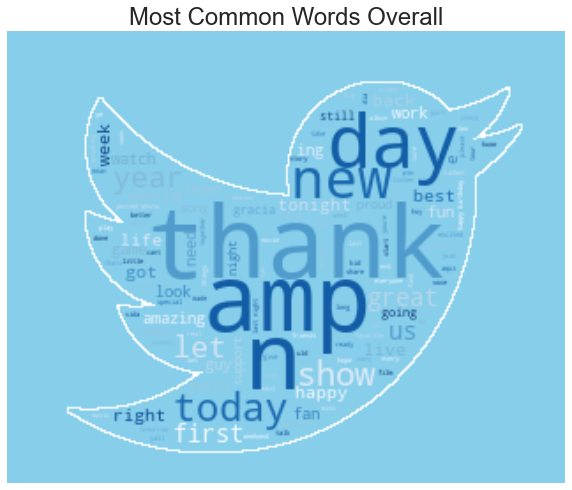

In [10]:
# show the viz for q2a
mvp_explore.q2a_vis(train)

### Question 2b: What words are unique to introvert or extrovert?

In [11]:
# show the viz for q2b
mvp_explore.q2b_vis(train)

placeholder


#### Hypothesis 2:

    Ho -> The mean tweet length is shorter or equal for extroverts than introverts
    Ha -> The mean tweet length is longer for extroverts than introverts
    T-Test, Two-Sample, One-Tailed

In [12]:
# show the stats results for q2b
mvp_explore.q2b_stats(train)


        Fail to Reject the Null Hypothesis.
        Findings suggest the mean tweet length is shorter or equal for extroverts compared to introverts.
        


### Question 2 Takeaways
- There is not a significant difference in average tweet length when comparing introverts and extroverts

---
### Question 3: Is there a relationship between word count and personality type?

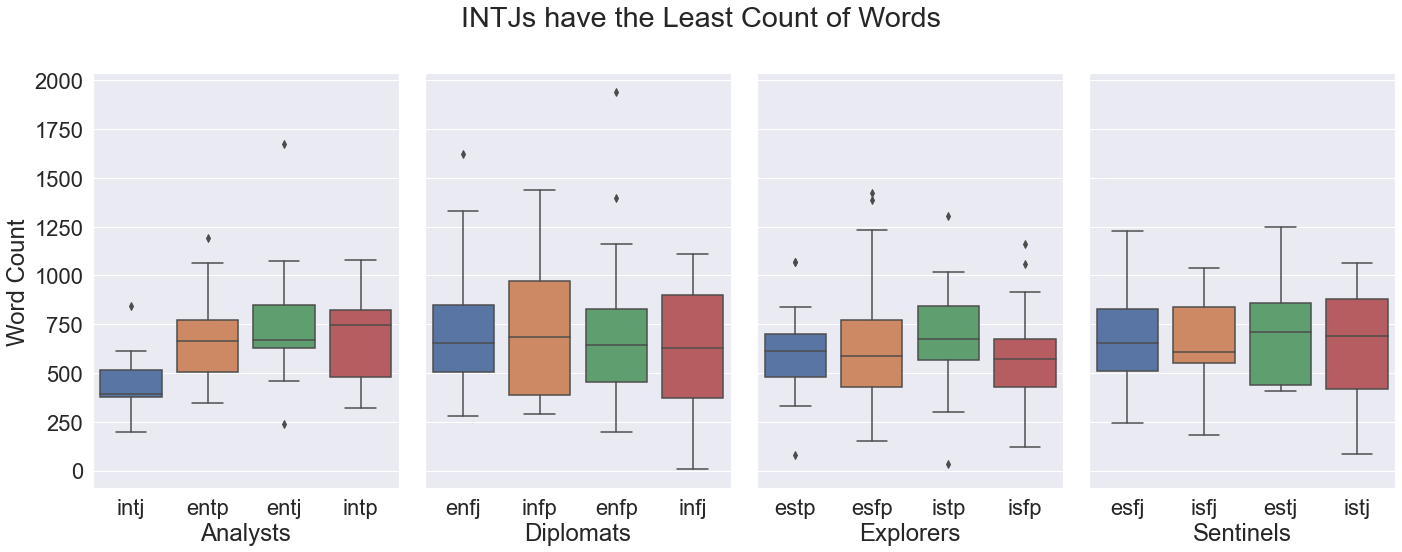

In [13]:
# show the viz for q3
mvp_explore.q3_vis(train)

In [14]:
# show the stats results for q3
mvp_explore.q3_stats(train)

placeholder


### Question 3 Takeaways
- Across the board there are mostly consistent word counts for domains and the 16 personalities
- INTJ is the one exception to this, and it is likely due to a lack of data for that type

---
## Data Modeling
The goal is to maximize accuracy.

| Features Dropped | Features Kept |
| ---- | ---- |
| pairs | lemmatized |
| domain | bow |
| sentiment | TF-IDF |
| message_length |  |
| word_count |  |
|  |  |

In [15]:
# get the baseline accuracy
mvp_model.get_baseline(df)

'Baseline Accuracy: 17.2'

In [16]:
# get the model results on train and validate
mvp_model.top_3_16_personalities(df)

Top Model per Feature
-------------
Bag of Words MultinomialNB Train Accuracy: 84.96%
-------------
Bag of Words MultinomialNB Validate Accuracy: 17.50%
-------------
TF-IDF MultinomialNB Train Accuracy: 25.63%
-------------
TF-IDF MultinomialNB Validate Accuracy: 17.50%
-------------


Top Clustering Model
-------------
Cluster MultinomialNB Train Accuracy: 19.50%
-------------
Cluster MultinomialNB Validate Accuracy: 15.00%
-------------


In [17]:
# get the best model's results on test
mvp_model.test_16_personalities(df)

-------------
TF-IDF MultinomialNB Test Accuracy: 17.50%
-------------


### Modeling Takeaways:
- The best model was the TF-IDF Multinomial Naive Bayes model at % accuracy on test.
- The other models showed strong signs of overfitting the data on train, but were producing similar results on validate.

---
## Conclusion
Using a tweets to analyze behavior and classify into one of the 16 Myers Briggs personality types is not a reliable method. Our best model performed at 17.5% accuracy vs baseline's 17.2%. 

### Recommendations
- Due to the low accuracy, it is not recommended to use this for individual predictions
- However, looking at how types and domains interact can provide business insights for targeted marketing and training for known personality types

### Next Steps:
- Try two new approaches in modeling:
    - classifying based on domain
    - completing 4 regressions on each pair and concatenating the results
- Explore further associations in the words to inlcude emojis, swear words, ect. 
---